In [26]:
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import os
import math


# Import data

Field Inventory Data

In [2]:
data = os.getcwd()+"/data/"
with open(data+"field_survey.geojson") as f:
    field_survey = gpd.read_file(f)
field_survey.shape
field_survey.head()

,plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
0,1.0,1.0,Birch,47.2,46.2,46.70,NaN,26.5,0.0,None,POINT (547075.84 6450425.243)
1,1.0,2.0,Aspen,27.9,29.1,28.50,NaN,NaN,0.0,None,POINT (547074.299 6450419.542)
2,1.0,3.0,Fir,12.1,13.0,12.55,NaN,NaN,0.0,None,POINT (547077.454 6450419.994)
3,1.0,4.0,Aspen,23.3,23.7,23.50,69.0,27.4,0.0,None,POINT (547078.211 6450419.02)
4,1.0,5.0,Aspen,23.2,31.3,27.25,NaN,NaN,0.0,None,POINT (547074.669 6450415.573)


In [3]:
height_described = field_survey["height"].dropna().describe()
min_height = height_described["min"]
max_height = height_described["max"]

print(max_height)

34.2


Lidar data

In [28]:
def load_lidar():
    for i in range(1,11):
        temp = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz
        tempdf = pd.DataFrame(temp)
        tempdf["plot"] = i
        tempdf = tempdf.rename(columns={0: "x", 1: "y", 2: "z"})
        if i == 1:
            lidardf = tempdf
        else:
            lidardf = pd.concat([lidardf,tempdf],ignore_index= True)
    return(lidardf)

lidardf = load_lidar()

RangeIndex(start=0, stop=2739182, step=1)


Take a look at our point clouds

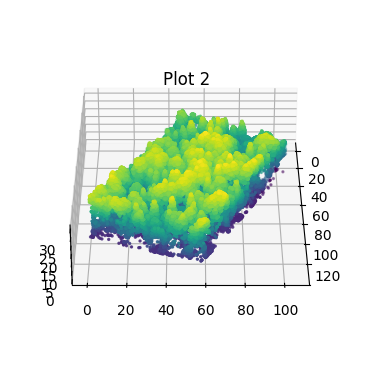

In [5]:
def plot_3d_cloud(df,i):
    #plot1 = laspy.read(data+"/als/plot_"+ "0"*(2-len(str(i))) + str(i) + ".las").xyz
    plot = df.loc[df["plot"] == i]
    plot = plot.drop(columns=['plot']).to_numpy()
    plot -= plot.min(axis=0, keepdims=True)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1, projection="3d")

    ax.scatter(
        *plot.swapaxes(0, 1),
        c=plot[:, 2],
        s=2,
    )

    ax.view_init(elev=30, azim=0)

    ax.set_title("Plot " + str (i), y=0.83)

    ax.set_aspect("equal")
plot_3d_cloud(lidardf,2)

# Filtering

In [ ]:
def distance(p1,p2):
    return(math.sqrt(((p2[0] - p1[0])**2) + ((p2[1] - p1[1])**2) + ((p2[2] - p1[2])**2)))
                   

def num_neigh(i,l):
    num = 0
    for el in l:
        if i in el:
            num += 1
    return(num)

def neighbourlist(df,plotnum,r):
    points = df.loc[df["plot"] == plotnum]
    indexes = np.asarray(points.index)
    points = points.to_numpy()
    temp = []
    firstindex = np.asarray(indexes)[0]
    for i in indexes:
        if (i)%10 == 0:
            print(str((i-firstindex)/len(indexes)))
        for j in indexes:
            if i < j:
                d = distance(np.asarray(lidardf.loc[i]),np.asarray(lidardf.loc[j]))
                if d < r:
                    temp += [[i,j]]
    res = [num_neigh(i,temp) for i in indexes]
    return(res)

def load_filter(a):
    df = load_lidar()

    #Filter out lower a quantile, where the quantiles are computed plot per plot
    #Otherwise, if the ground level is not the same for each plot we remove
    #inequally between the different plots

    for i in df["plot"].unique():
        Q = df.loc[df["plot"] == i].quantile(a)                 #compute quantile of plot
        zQ = Q["z"]                                             #keep only height quantile
        df = df.loc[-((df["z"] < zQ) & (df["plot"] == i))]      #remove low points from selected plot

    #--------------

    return(df)

lidardf = load_filter(0.2)
print(neighbourlist(lidardf,2,1))


2.4605693757535495e-05
5.9756684839729056e-05
9.490767592192262e-05
0.00013005866700411617
